In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [3]:
data = pd.read_csv("datas/df_EDA.csv")
data.head()

,Marque,Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,maruti,wagon r lxi cng,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1925.0
1,hyundai,creta 1.6 crdi sx option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,13750.0
2,honda,jazz v,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4950.0
3,maruti,ertiga vdi,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6600.0
4,audi,a4 new 2.0 tdi multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,19514.0


In [4]:
x = data.drop("Price" ,axis =1)
y = data["Price"]

In [5]:
nominal = ["Transmission","Location","Fuel_Type","Marque","Model"]
ordinal = ["Owner_Type"]
numerical = x.select_dtypes(["Int64","float64"]).columns

In [6]:
x[numerical]= StandardScaler().fit_transform(x[numerical])

In [7]:
x

,Marque,Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,maruti,wagon r lxi cng,Mumbai,-1.098160,0.148414,CNG,Manual,First,1.971484,-1.043572,-1.023083,-0.352373
1,hyundai,creta 1.6 crdi sx option,Pune,0.481242,-0.188006,Diesel,Manual,First,0.312726,-0.072655,0.239987,-0.352373
2,honda,jazz v,Chennai,-0.782280,-0.133744,Petrol,Manual,First,-0.039132,-0.709404,-0.456150,-0.352373
3,maruti,ertiga vdi,Chennai,-0.466400,0.311198,Diesel,Manual,First,0.576021,-0.627940,-0.455036,2.132430
4,audi,a4 new 2.0 tdi multitronic,Coimbatore,-0.150519,-0.191587,Diesel,Automatic,Second,-0.757209,0.569082,0.511016,-0.352373
...,...,...,...,...,...,...,...,...,...,...,...,...
5869,maruti,swift vdi,Delhi,0.165361,-0.335976,Diesel,Manual,First,2.402330,-0.627940,-0.729035,-0.352373
5870,hyundai,xcent 1.1 crdi s,Jaipur,0.481242,0.452277,Diesel,Manual,First,1.444894,-0.840743,-0.784726,-0.352373
5871,mahindra,xylo d4 bsiv,Jaipur,-0.466400,-0.036074,Diesel,Manual,Second,-1.044439,1.450223,-0.023617,3.374831
5872,maruti,wagon r vxi,Kolkata,-0.150519,-0.133744,Petrol,Manual,First,0.128420,-1.043572,-0.857124,-0.352373


In [8]:
transformation = {
    "First":3,
    "Second":2,
    "Third":1,
    "Fourth & Above":0
}

x["Owner_Type"] = x["Owner_Type"].map(transformation)

In [ ]:
import category_encoders as ce
binaryencoder = ce.BinaryEncoder(cols=nominal)
binaryencoder.fit(x)


BinaryEncoder(cols=['Transmission', 'Location', 'Fuel_Type', 'Marque', 'Model'],
              mapping=[{'col': 'Transmission',
                        'mapping':     Transmission_0  Transmission_1
 1               0               1
 2               1               0
-1               0               0
-2               0               0},
                       {'col': 'Location',
                        'mapping':      Location_0  Location_1  Location_2  Location_3
 1            0           0           0           1
 2            0           0           1           0
 3            0           0           1           1
 4            0           1           0           0
 5            0           1           0           1
 6            0           1           1           0
 7            0           1           1           1
 8            1           0           0           0
 9            1           0           0           1
 10           1           0           1           0
 11           1           0           1           1
-1            0           0           0           0
-2            0           0           0           0},
                       {'col': 'Fuel_Type',
                        'mapping':     Fuel_Type_0  Fuel_Type_...
 27         1         1         0         1         1
 28         1         1         1         0         0
 29         1         1         1         0         1
-1          0         0         0         0         0
-2          0         0         0         0         0},
                       {'col': 'Model',
                        'mapping':        Model_0  Model_1  Model_2  Model_3  Model_4  Model_5  Model_6  Model_7  \
 1           0        0        0        0        0        0        0        0   
 2           0        0        0        0        0        0        0        0   
 3           0        0        0        0        0        0        0        0   
 4           0        0        0        0        0        0        0        0   
 5           0        0        0        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
 1786        1        1        0        1        1        1        1        1   
 1787        1        1        0        1        1        1        1        1   
 1788        1        1        0        1        1        1        1        1   
-1           0        0        0        0        0        0        0        0   
-2           0        0        0        0        0        0        0        0   

       Model_8  Model_9  Model_10  
 1           0        0         1  
 2           0        1         0  
 3           0        1         1  
 4           1        0         0  
 5           1        0         1  
...        ...      ...       ...  
 1786        0        1         0  
 1787        0        1         1  
 1788        1        0         0  
-1           0        0         0  
-2           0        0         0  

[1790 rows x 11 columns]}])

In [10]:
x = binaryencoder.transform(x)


In [11]:
x

,Marque_0,Marque_1,Marque_2,Marque_3,Marque_4,Model_0,Model_1,Model_2,Model_3,Model_4,...,Fuel_Type_0,Fuel_Type_1,Fuel_Type_2,Transmission_0,Transmission_1,Owner_Type,Mileage,Engine,Power,Seats
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,3,1.971484,-1.043572,-1.023083,-0.352373
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,3,0.312726,-0.072655,0.239987,-0.352373
2,0,0,0,1,1,0,0,0,0,0,...,0,1,1,0,1,3,-0.039132,-0.709404,-0.456150,-0.352373
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,3,0.576021,-0.627940,-0.455036,2.132430
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,2,-0.757209,0.569082,0.511016,-0.352373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,3,2.402330,-0.627940,-0.729035,-0.352373
5870,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,3,1.444894,-0.840743,-0.784726,-0.352373
5871,0,1,1,1,0,1,1,0,1,1,...,0,1,0,0,1,2,-1.044439,1.450223,-0.023617,3.374831
5872,0,0,0,0,1,0,0,0,1,1,...,0,1,1,0,1,3,0.128420,-1.043572,-0.857124,-0.352373


In [12]:
x_train ,x_test ,y_train ,y_test =train_test_split(x,y,random_state=42 ,shuffle=True ,test_size=.2)

In [13]:
print(x_train.shape)

(4699, 32)


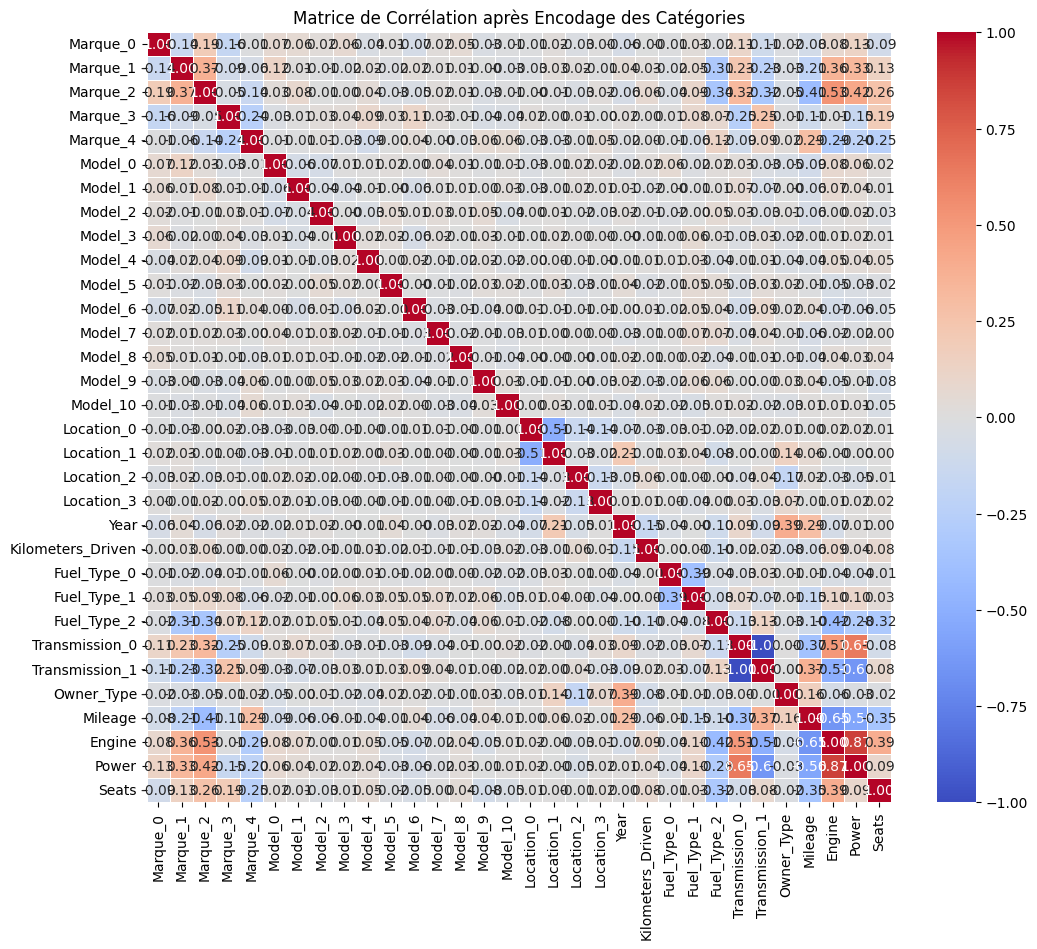

Colonnes après encodage :
Index(['Marque_0', 'Marque_1', 'Marque_2', 'Marque_3', 'Marque_4', 'Model_0',
       'Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 'Model_6',
       'Model_7', 'Model_8', 'Model_9', 'Model_10', 'Location_0', 'Location_1',
       'Location_2', 'Location_3', 'Year', 'Kilometers_Driven', 'Fuel_Type_0',
       'Fuel_Type_1', 'Fuel_Type_2', 'Transmission_0', 'Transmission_1',
       'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats'],
      dtype='object')


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le dataset
data = pd.read_csv("datas/df_EDA.csv")  # Mets le bon chemin si nécessaire

# Encodage des variables catégorielles (One-Hot Encoding)
data_encoded = pd.get_dummies(x_train, drop_first=True)

# Sélectionner les colonnes numériques après encodage
numerical_columns = data_encoded.columns  # Inclut les colonnes encodées

# Calculer la matrice de corrélation
correlation_matrix = data_encoded.corr()

# Afficher la heatmap avec annotations numériques
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation après Encodage des Catégories")
plt.show()

# Afficher les noms des colonnes après encodage
print("Colonnes après encodage :")
print(data_encoded.columns)